# Exploring some of the classified SN light-curves

In [1]:
import sys
import glob,os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
sys.path.append("../")
import utils.data_utils as du
import utils.visualization_utils as vu

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Init paths
raw_dir = os.environ.get("DES_DATA")
debug=False

## Load photometry

In [3]:
# load fits files
df_fits = {}
for dtype in ["fake", "real"]:
    # load fits files and merge them in one
    bazin_file = f"{Path(raw_dir)}/DESALL_forcePhoto_{dtype}_snana_fits/DESALL_{dtype}_Bazin_fit.SNANA.TEXT"
    clump_file = f"{Path(raw_dir)}/DESALL_forcePhoto_{dtype}_snana_fits/DESALL_{dtype}_clump.SNANA.TEXT"
    if Path(bazin_file).exists():
        df_bazin = du.load_fits(bazin_file)
    if Path(clump_file).exists():
        df_clump = du.load_fits(clump_file)
    df_clump['PKMJD_clump'] = df_clump['PKMJDINI']
    df_fits[dtype] = df_clump[['SNID','PKMJD_clump']]
    df_fits[dtype] = df_fits[dtype].merge(df_bazin,on='SNID')
    df_fits[dtype] = df_fits[dtype][['SNID', 'PKMJD_clump','TYPE', 
       'CUTFLAG_SNANA', 'zCMB', 'zCMBERR', 'zHD', 'zHDERR',
       'VPEC', 'VPECERR', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'HOST_sSFR',
       'HOST_sSFR_ERR', 'PKMJDINI', 'FIT_T0_g', 'FIT_T0_r', 'FIT_T0_i',
       'FIT_T0_z', 'FIT_TRISE_g', 'FIT_TRISE_r', 'FIT_TRISE_i', 'FIT_TRISE_z',
       'FIT_TFALL_g', 'FIT_TFALL_r', 'FIT_TFALL_i', 'FIT_TFALL_z', 'FIT_A0_g',
       'FIT_A0_r', 'FIT_A0_i', 'FIT_A0_z', 'FIT_A1_g', 'FIT_A1_r', 'FIT_A1_i',
       'FIT_A1_z', 'FIT_A2_g', 'FIT_A2_r', 'FIT_A2_i', 'FIT_A2_z',
       'PKMJD_FIT_g', 'PKMJD_ERR_g', 'PKMJD_FIT_r', 'PKMJD_ERR_r',
       'PKMJD_FIT_i', 'PKMJD_ERR_i', 'PKMJD_FIT_z', 'PKMJD_ERR_z',
       'FIT_CHI2_g', 'FIT_CHI2_r', 'FIT_CHI2_i', 'FIT_CHI2_z', 'FIT_NDOF_g',
       'FIT_NDOF_r', 'FIT_NDOF_i', 'FIT_NDOF_z', 'SNRMAX1', 'SNRMAX2',
       'SNRMAX3']]

In [4]:
# load complete data
# BEWARE! this is the complete yearly stack, if you want to look at the SNN light-curves use the SNN module!
df = {} # only header
df_w_photo = {} # merged with photometry

#load photometry and header fits tables
# horrible way of doing this! but it is to play with the data

for dtype in ["fake", "real"]:    
    list_files = glob.glob(os.path.join(f"{raw_dir}/DESALL_forcePhoto_{dtype}_snana_fits/", "*PHOT.FITS"))
    df_head_tmp = []
    df_head_w_phot_tmp = []
    
    for fname in list_files:
        df_header, df_phot = du.read_fits(fname)
        df_header = pd.merge(df_header, df_fits[dtype], on='SNID')
        df_header = df_header[[
            k for k in df_header.keys() if 'Unnamed' not in k]]
        df_head_tmp.append(df_header)
        df_head_w_phot_tmp.append(df_header.merge(df_phot,on='SNID'))
        
    df[dtype] = pd.concat(df_head_tmp)
    df_w_photo[dtype] = pd.concat(df_head_w_phot_tmp)

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



## Load predictions

In [14]:
# model
model_name = "vanilla_S_0_CLF_2_R_None_photometry_DF_1.0_N_global_lstm_32x2_0.05_128_True_mean_C"
# load predictions 
df_pred = {}
for dtype in ["fake", "real"]:   
    pred_dir = f'../dumps/{dtype}/clump/models/'
    pred_file = f'{pred_dir}/{model_name}/PRED_{model_name}.pickle'
    df_pred[dtype] = pd.read_pickle(pred_file)

## Selecting SNe for inspection
e.g. lets find those spectroscopic Ias that are not photometrically classified as Ias. 

In [20]:
# We set probability of classification 0.5 as threshold
# remember class0=prob of being Ia
SNN_nonIa = df_pred["real"][df_pred["real"]['all_class1']>0.5]

In [23]:
# now get Ids for spectroscopic Ias
spec_Ia = df["real"][(df["real"]["SNTYPE"]==1) | (df["real"]["SNTYPE"]==101)]

In [24]:
# now lets see which SNe (IDs) are spec Ias but not classified as Ias
ids_lost_spec_Ia = [i for i in SNN_nonIa.SNID.values if i in spec_Ia.SNID.values]

In [31]:
# select the photometry only for these "lost ias"
df_sel = df["real"][df["real"].SNID.isin(ids_lost_spec_Ia)]

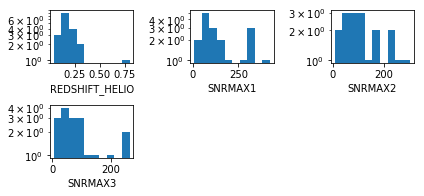

In [37]:
# General properties
list_var = ["REDSHIFT_HELIO",'SNRMAX1', 'SNRMAX2','SNRMAX3']
fig = plt.figure()
for i,var in enumerate(list_var):
    ax=plt.subplot(3,3,i+1)
    ax.hist(df_sel[var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

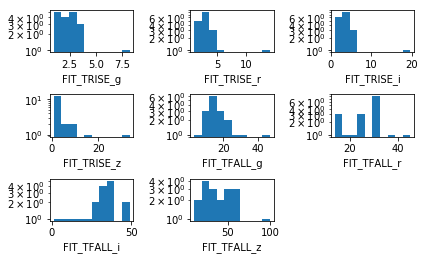

In [38]:
# bazin fit properties
list_var = ['FIT_TRISE_g', 'FIT_TRISE_r', 'FIT_TRISE_i', 'FIT_TRISE_z',
       'FIT_TFALL_g', 'FIT_TFALL_r', 'FIT_TFALL_i', 'FIT_TFALL_z']
fig = plt.figure()
for i,var in enumerate(list_var):
    ax=plt.subplot(3,3,i+1)
    ax.hist(df_sel[var])
    ax.set_yscale("log")
    ax.set_xlabel(var)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [39]:
# now lets plot some of these random lcs
df_sel_w_photo = df_w_photo["real"][df_w_photo["real"].SNID.isin(ids_lost_spec_Ia)]

[Plot light-curves] 


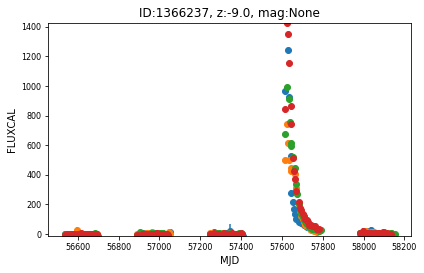

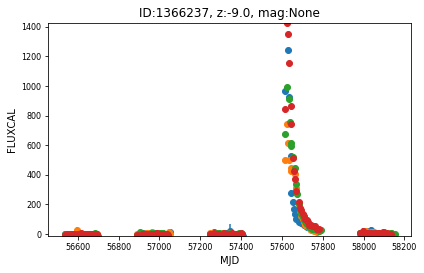

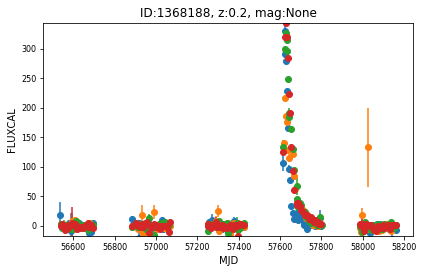

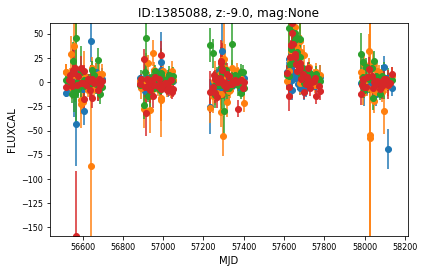

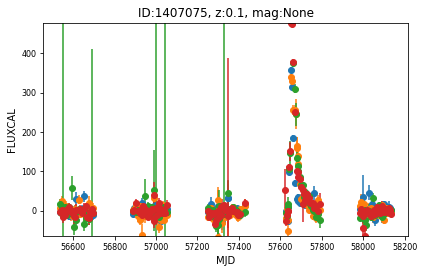

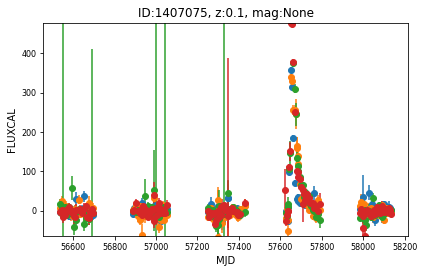

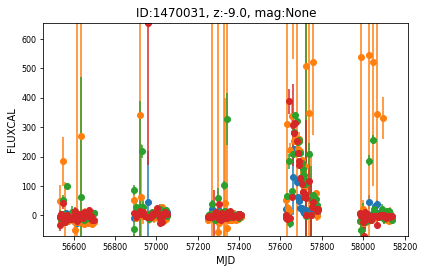

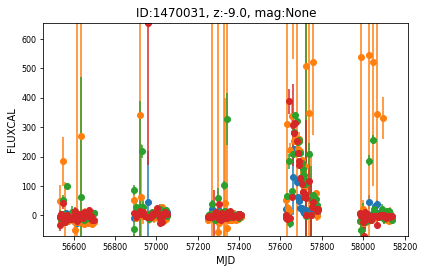

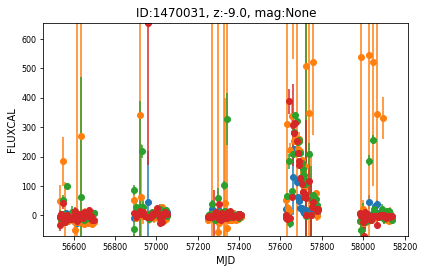

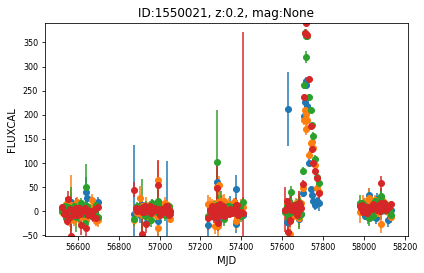

In [40]:
# this will save the plots as well
vu.plot_random_lcs(df_sel_w_photo, f'../dumps/real/clump/lightcurves/{model_name}/spec_Ia_classified_as_nonIa_yearly_stack/', multiplots=False, nb_lcs=10, plot_peak=False)

# Inspecting using SNN
this allows us to look at exactly the photometry that SNN uses instead of yearly stacks

In [43]:
model_files = [
    f"../SuperNNova_general/trained_models_mutant/{model_name}/{model_name}.pt"]
skim_dir = f"./dumps/real/clump/"
out_dir = '../dumps/spec_Ia_classified_as_nonIa_SNN/'

In [44]:
vu.plot_early_classification(skim_dir , prefix='photo_Ia_', df=df_sel_w_photo, model_files=model_files, out_dir=out_dir)

usage: ipykernel_launcher.py [-h] [--seed SEED] [--data] [--train_rnn]
                             [--train_rf] [--validate_rnn] [--validate_rf]
                             [--override_source_data {photometry,saltfit}]
                             [--explore_lightcurves] [--speed]
                             [--monitor_interval MONITOR_INTERVAL] [--metrics]
                             [--performance] [--science_plots] [--calibration]
                             [--plot_lcs] [--plot_prediction_distribution]
                             [--model_files MODEL_FILES [MODEL_FILES ...]]
                             [--prediction_files PREDICTION_FILES [PREDICTION_FILES ...]]
                             [--metric_files METRIC_FILES [METRIC_FILES ...]]
                             [--done_file DONE_FILE] [--viz_plasticc]
                             [--train_plasticc] [--predict_plasticc]
                             [--data_plasticc_train] [--data_plasticc_test]
                         

SystemExit: 2

/Users/anaismoller/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
